In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Ignore Warning message
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import re
import random
import os

# Scoring
from sklearn.metrics import f1_score

# Validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Visualization
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import lightgbm
import xgboost
# import catboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

# LDA
import gensim
from gensim import corpora, models
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

In [62]:
data = pd.read_csv('/content/drive/MyDrive/DACON/Law_predict/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DACON/Law_predict/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/DACON/Law_predict/sample_submission.csv')

In [63]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

# FEATRUE ENGINEERING

In [64]:
data['first_party'].value_counts()

United States       154
Illinois              9
Maryland              8
Florida               8
New York              7
                   ... 
David Carpenter       1
Larry Gene Heath      1
PGA TOUR, Inc.        1
PPL Montana, LLC      1
Markman               1
Name: first_party, Length: 2110, dtype: int64

In [65]:
data['second_party'].value_counts()

United States                        240
California                            19
United States of America              15
Illinois                              13
Federal Communications Commission     10
                                    ... 
David Boren, Governor of Oklahoma      1
Federal Bureau of Prisons et al.       1
Town of Harrison                       1
Charles Burr et al.                    1
Westview Instruments, Inc.             1
Name: second_party, Length: 1974, dtype: int64

In [66]:
# 출력 옵션 설정
# pd.set_option("display.max_rows", None)  # 모든 행 표시
pd.set_option("display.max_columns", None)  # 모든 열 표시
pd.set_option("display.width", None)  # 줄 바꿈 없이 전체 내용 표시
data['facts']

0       On June 27, 1962, Phil St. Amant, a candidate ...
1       Ramon Nelson was riding his bike when he suffe...
2       An Alabama state court convicted Billy Joe Mag...
3       Victor Linkletter was convicted in state court...
4       On April 24, 1953 in Selma, Alabama, an intrud...
                              ...                        
2473    Congress amended the Clean Air Act through the...
2474    Alliance Bond Fund, Inc., an investment fund, ...
2475    In 1992, the District Court sentenced Manuel D...
2476    On March 8, 1996, Enrico St. Cyr, a lawful per...
2477    Herbert Markman owns the patent to a system th...
Name: facts, Length: 2478, dtype: object

In [67]:
data.iloc[0]['facts']

'On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana.  During this speech, St. Amant accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union.  Finally, St. Amant implicated Herman Thompson, an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and St. Amant’s political opponent. \nThompson successfully sued St. Amant for defamation.  Louisiana’s First Circuit Court of Appeals reversed, holding that Thompson did not show St. Amant acted with “malice.”  Thompson then appealed to the Supreme Court of Louisiana.  That court held that, although public figures forfeit some of their First Amendment protection from defamation, St. Amant accused Thompson of a crime with utter disregard of whether the remarks were true.  Finally, that court held that the First Amendment protects uninhibited, robust debate, rather t

In [68]:
# 다운샘플링
from sklearn.utils import resample

subset_0 = data[data["first_party_winner"] == 0]
subset_1 = data[data["first_party_winner"] == 1]

subset_1_downsampled = resample(subset_1,
                                replace=False,
                                n_samples=800,
                                random_state=42)

data = pd.concat([subset_0, subset_1_downsampled])

In [69]:
!pip install transformers

In [70]:
# transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers.tokenization_utils import TruncationStrategy

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


porter = PorterStemmer()

def stem_text_func(text):
    token_words=word_tokenize(text)
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [71]:
!pip install stop_words

In [72]:
from stop_words import get_stop_words
# 불용어 리스트
languages = [
   'English'
]
my_stop_word_list = []
for i in languages:
    my_stop_word_list.append(get_stop_words(i.lower()))
my_stop_word_list = sum(my_stop_word_list, [])
my_stop_word_list = my_stop_word_list + ['paperbook', 'hardcover']

In [73]:
# https://gist.github.com/nealrs/96342d8231b75cf4bb82
contractions = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}


In [74]:
import re

#main 단어만 추출 > 차후 이 단어들로 test
def preprocessing_sentence(sentence):
    #소문자화
    sentence = sentence.lower()
    #괄호로 닫친 문자열 괄호 제거
    sentence = re.sub(r'\([^)]*\)',' ',sentence)
    #쌍따옴표 제거
    sentence = re.sub('"', ' ', sentence)
    #약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    #소유격 제거
    sentence = re.sub(r"'s\b"," ",sentence)
    #특수문자 제거
    sentence = re.sub("[^a-zA-Z]"," ", sentence)

    #불용어 제거
    if my_stop_word_list:
        tokens = ' '.join(word for word in sentence.split() if not word in my_stop_word_list if len(word)>1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word)>1)
    return tokens


In [75]:
data['facts'] = [preprocessing_sentence(i) for i in data['facts']]
test['facts'] = [preprocessing_sentence(i) for i in test['facts']]

In [76]:
def preprocessing_party(party):
    #소문자화
    sentence = sentence.lower()
    #괄호로 닫친 문자열 괄호 제거
    sentence = re.sub(r'\([^)]*\)',' ',sentence)
    #반점 제거
    sentence = re.sub(',', ' ', sentence)
    #특수문자 제거
    sentence = re.sub("[^a-zA-Z]"," ", sentence)
    return party

In [77]:
data['first_party'] = [preprocessing_sentence(i) for i in data['first_party']]
data['second_party'] = [preprocessing_sentence(i) for i in data['second_party']]
test['first_party'] = [preprocessing_sentence(i) for i in test['first_party']]
test['second_party'] = [preprocessing_sentence(i) for i in test['second_party']]

In [78]:
data

,ID,first_party,second_party,facts,first_party_winner
1,TRAIN_0001,stephen duncan,lawrence owens,ramon nelson riding bike suffered lethal blow ...,0
3,TRAIN_0003,linkletter,walker,victor linkletter convicted state court eviden...,0
14,TRAIN_0014,james thole et al,bank et al,named plaintiff james thole others brought cla...,0
16,TRAIN_0016,plyler,doe,revision texas education laws allowed state wi...,0
21,TRAIN_0021,bassam yacoub salman,united states,maher kara joined citigroup healthcare investm...,0
...,...,...,...,...,...
951,TRAIN_0951,ben ysursa idaho secretary state et al,pocatello education association et al,plaintiffs case comprised labor organizations ...,1
1360,TRAIN_1360,michael sexton warden,nicholas beaudreaux,nicholas beaudreaux shot killed wayne drummond...,1
1070,TRAIN_1070,dickinson,zurko,mary zurko others applied patent upon method i...,1
1035,TRAIN_1035,georgia,john ashcroft attorney general,following census democratic controlled georgia...,1


In [79]:
import nltk
from nltk.stem import WordNetLemmatizer

# Penn Treebank POS 태그를 WordNet POS 태그로 변환하는 함수
def penn_to_wn(tag):
    if tag is None:
        return None
    elif tag.startswith('N'):
        return 'n'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('J'):
        return 'a'
    elif tag.startswith('R'):
        return 'r'
    else:
        return None
wnl = WordNetLemmatizer()
# 데이터프레임에서 'facts' 칼럼 선택 후, 각 문장에 대해 lemmatization과 품사 태깅 적용
data['facts'] = data['facts'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos=penn_to_wn(pos)) for word, pos in nltk.pos_tag(nltk.word_tokenize(x)) if penn_to_wn(pos) is not None]))
test['facts'] = test['facts'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos=penn_to_wn(pos)) for word, pos in nltk.pos_tag(nltk.word_tokenize(x)) if penn_to_wn(pos) is not None]))

In [80]:
data.iloc[0]['facts']

'ramon nelson rid bike suffer lethal blow back head baseball bat eyewitness identify lawrence owen array photos lineup try convict nelson death nelson carry cocaine crack cocaine potentially distribution judge owens bench trial rule owen probably also drug dealer try knock nelson owens find guilty first degree murder sentence year prison owens file petition writ habeas corpus ground constitutional right due process violate trial argue eyewitness identification inadmissible base unreliability judge impermissibly infer motive motive element offense district court deny writ habeas corpus owen appeal court appeal seventh circuit reverse denial hold trial judge inference owen motive violate right guilt adjudicate solely base evidence present trial'

In [81]:
data['facts'] = data['facts'].astype('str')
test['facts'] = test['facts'].astype('str')

In [82]:
facts_corpus_lose = ' '.join(data[data['first_party_winner'] == 0]['facts'])
facts_corpus_win = ' '.join(data[data['first_party_winner'] == 1]['facts'])

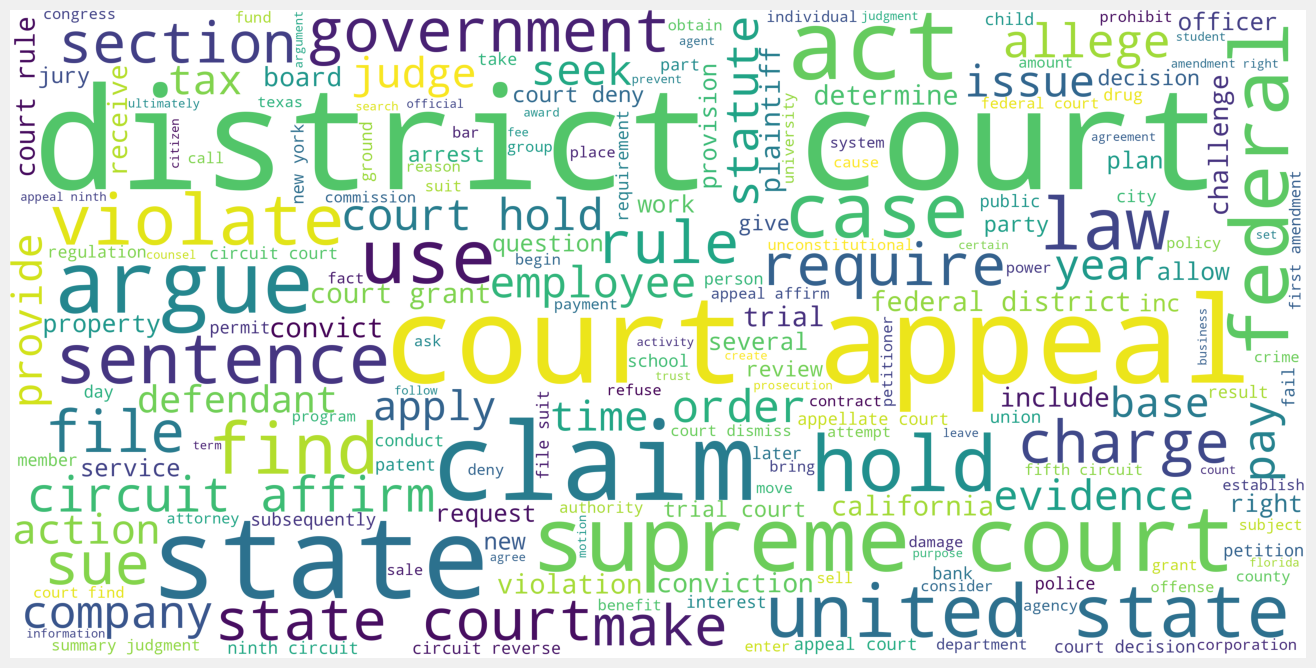

In [83]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(facts_corpus_lose)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

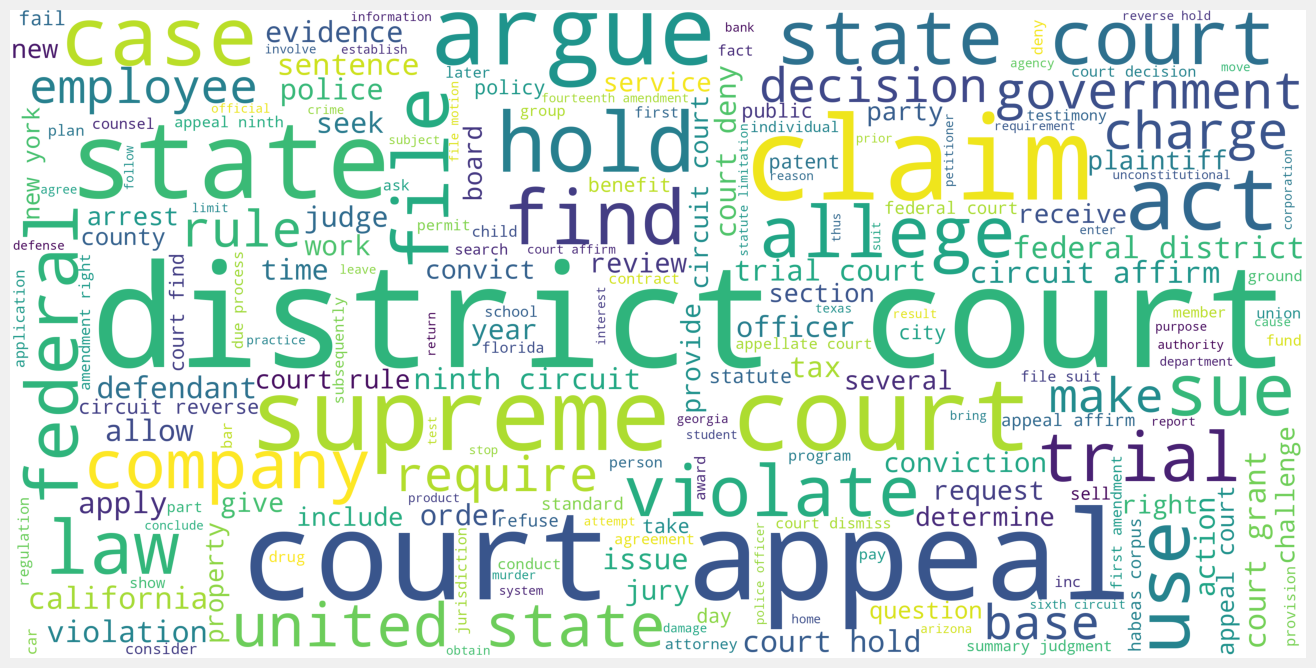

In [84]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(facts_corpus_win)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

# model train

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts'])
    else:
        X_facts = vectorizer.transform(df['facts'])
    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])

    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

In [86]:
X = get_vector(vectorizer, data, True)
Y = data["first_party_winner"]
X_T = get_vector(vectorizer, test, False)

In [87]:
X = np.squeeze(np.asarray(X))
X_T = np.squeeze(np.asarray(X_T))

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [89]:
# cat_params = {
#                 'verbose' : 100,
#                 'random_state': 113,
#                # 'use_best_model' : True,
#              }

In [90]:
from sklearn import svm
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


# Classifiers
names = [
    "Logistic Regression",
    "KNN Classifier",
    # "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    # "XGBoost",
    # "AdaBoost",
    # "Catboost",
]

models = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    # DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100),
    SGDClassifier(loss = 'hinge'),
    RidgeClassifier(),
    # XGBClassifier(),
    # AdaBoostClassifier(),
    # CatBoostClassifier(**cat_params)
]

# models = [
#     ('gbm', GradientBoostingClassifier(n_estimators=100, random_state=1)),
#     ('lr',LogisticRegression()),
#     ('knn',KNeighborsClassifier(n_neighbors = 149, n_jobs = -1)),
#     ('dt',DecisionTreeClassifier()),
#     ('svc',svm.SVC(kernel = 'linear')),
#     ('rf',RandomForestClassifier(n_estimators = 100)),
#     ('sgd',SGDClassifier(loss = 'hinge')),
#     ('rc',RidgeClassifier()),
#     ('xgb',XGBClassifier()),
#     ('adc',AdaBoostClassifier()),
#     ('cat',CatBoostClassifier(**cat_params))
# ]

In [91]:
import time
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    x = time.time()
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))

    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df

In [92]:
score(X_train, y_train, X_test, y_test, names = names, models = models)

,Classifier,Training accuracy,Validation accuracy
1,KNN Classifier,0.563315,0.592025
4,SGD Classifier,1.000000,0.588957
0,Logistic Regression,0.985418,0.564417
5,Ridge Classifier,1.000000,0.564417
2,Linear SVM,0.997698,0.555215
3,Random Forest,1.000000,0.542945


In [93]:
X = pd.DataFrame(X)
X = X.values
Y = pd.DataFrame(Y)
Y = Y.values
X_T = pd.DataFrame(X_T)
X_T = X_T.values

In [94]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 모델 학습과 평가
scores = []
for train_index, test_index in kfold.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    model = SGDClassifier()
    model.fit(X_train, y_train)  # 모델 학습
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

# 교차 검증 결과 평균 정확도 계산
mean_score = sum(scores) / len(scores)
print("평균 정확도:", mean_score)

평균 정확도: 0.5309882019820671


In [40]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.9 MB/s eta 0:00:00


In [95]:
from sklearn.datasets import make_classification
import optuna

def objective(trial):

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # 튜닝할 파라미터
    loss = trial.suggest_categorical('loss', ['hinge', 'log', 'modified_huber'])
    penalty = trial.suggest_categorical('penalty', ['elasticnet', 'l1', 'l2'])
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive'])
    eta0 = trial.suggest_loguniform('eta0', 1e-5, 1e-1)
    power_t = trial.suggest_uniform('power_t', 0.1, 1.0)
    early_stopping = trial.suggest_categorical('early_stopping', [True, False])
    validation_fraction = trial.suggest_uniform('validation_fraction', 0.1, 0.3)
    n_iter_no_change = trial.suggest_int('n_iter_no_change', 5, 20)

    # 모델 초기화
    model = SGDClassifier(loss=loss, penalty=penalty, alpha=alpha, max_iter=max_iter,
                          learning_rate=learning_rate, eta0=eta0, power_t=power_t,
                          early_stopping=early_stopping, validation_fraction=validation_fraction,
                          n_iter_no_change=n_iter_no_change, random_state=42)

    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 평가 지표 계산
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 최적의 파라미터 출력
print('Best parameters:', study.best_params)
print('Best accuracy:', study.best_value)

[I 2023-07-03 02:06:41,601] A new study created in memory with name: no-name-06ba6885-c387-4617-95e1-215e00289f3b
[I 2023-07-03 02:06:44,401] Trial 0 finished with value: 0.6134969325153374 and parameters: {'loss': 'log', 'penalty': 'l1', 'alpha': 1.1263159915500147e-05, 'max_iter': 176, 'learning_rate': 'invscaling', 'eta0': 0.00055474664241244, 'power_t': 0.6870504955038345, 'early_stopping': False, 'validation_fraction': 0.19616406194285846, 'n_iter_no_change': 5}. Best is trial 0 with value: 0.6134969325153374.
[I 2023-07-03 02:06:46,035] Trial 1 finished with value: 0.4785276073619632 and parameters: {'loss': 'log', 'penalty': 'l2', 'alpha': 1.4153143953490082e-05, 'max_iter': 456, 'learning_rate': 'invscaling', 'eta0': 3.5553676165516715e-05, 'power_t': 0.17373268805447484, 'early_stopping': False, 'validation_fraction': 0.197300575279658, 'n_iter_no_change': 7}. Best is trial 0 with value: 0.6134969325153374.
[I 2023-07-03 02:07:22,242] Trial 2 finished with value: 0.54601226993

KeyboardInterrupt: ignored

In [49]:
# 최적화된 파라미터
best_params = study.best_params

# 데이터셋 생성
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 모델 초기화 및 최적의 파라미터로 설정
model = SGDClassifier(**best_params, random_state=42)

# 모델 학습
model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.6042944785276073


In [50]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 모델 학습과 평가
scores = []
for train_index, test_index in kfold.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    model = SGDClassifier(**best_params, random_state=42)
    model.fit(X_train, y_train)  # 모델 학습
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

# 교차 검증 결과 평균 정확도 계산
print('Cross-validation accuracies:', accuracy)
print('Mean accuracy:', np.mean(accuracy))

Cross-validation accuracies: 0.6042944785276073
Mean accuracy: 0.6042944785276073


In [51]:
# from sklearn.linear_model import RidgeClassifier
# from sklearn.model_selection import GridSearchCV

# def ridge_tuning(X, Y, params):
#     model = RidgeClassifier()
#     grid = GridSearchCV(model, params, scoring='accuracy', cv=5)
#     grid.fit(X, Y)

#     print(grid.best_params_)
#     print(grid.best_score_)

#     return grid.best_estimator_

# # 튜닝할 하이퍼파라미터 후보들
# params = {
#     'alpha': [0.1, 1.0, 10.0],
#     'fit_intercept': [True, False],
#     'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
# }

# # RidgeClassifier 모델의 하이퍼파라미터 튜닝
# best_model = ridge_tuning(X, Y, params)

In [52]:
# from sklearn.model_selection import GridSearchCV

# ## 하이퍼파라미터 튜닝용 함수
# def logistic_tuning(X, y, params):

#     model = RidgeClassifier(random_state = 42)
#     # 파라미터 튜닝(train data 전체를 넣어서 5-fold cv)
#     grid = GridSearchCV(model, params, scoring = 'accuracy', cv = 5)
#     grid.fit(X, y)

#     print(grid.best_params_)
#     print(grid.best_score_)

#     return grid.best_estimator_

In [53]:
# %%time
# param1 = {'alpha': [0.1, 1.0, 10.0],  'fit_intercept': [True, False], 'max_iter': [100, 300, 500, 1000]}
# logistic_tuning(X, Y, params = param1)

In [54]:
# !pip install optuna

In [55]:
# # optuna 관련 패키지 불러오기
# import optuna
# from optuna import Trial
# from optuna.samplers import TPESampler

# # 로지스틱 회귀 모델, 교차검증 평가지표 불러오기
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score

# # 하이퍼파라미터를 탐색할 함수
# def objectiveLR(trial: Trial, X, Y):
#     # 조정할 하이퍼 파라미터
#     params = {
#         "penalty" : ['l2'],
#         "C": trial.suggest_float('C', 8e-3, 0.5),
#         "max_iter": [10, 25, 50],
#         "class_weight": {0:1, 1:trial.suggest_float('class_weight', 1,1.5)},
#         "solver": trial.suggest_categorical('solver', ['liblinear']),
#         "random_state": 42,
#     }
#     # Logistic Regression 모델 객체 생성, parameter 넣어주기
#     model=LogisticRegression(**params)

#     # 교차검증 수행, 평가지표는 ROC AUC, 5번 수행해서 그 평균을 점수로 반영
#     score=cross_val_score(model, X, Y, cv=5, scoring='roc_auc').mean()

#     # 점수를 반환해서 피드백하게 함
#     return score

In [56]:
# # study 객체 생성
# # direction: score 값을 최대 또는 최소로 하는 방향으로 지정, RMSE는 score가 낮을 수록 좋은 성능을 나타내기 때문에 이를 정할 수 있게 한듯
# study = optuna.create_study(direction='maximize', sampler=TPESampler())

# # 옵티마이저 생성
# # n_trials: 시도 횟수 (미 입력시 Key interrupt가 있을 때까지 무한 반복)
# study.optimize(lambda trial:objectiveLR(trial, X, Y), n_trials=50)

# # 결과 확인
# print(f'Best trial: score{study.best_trial.value}\nBest params: {study.best_trial.params}')

In [57]:
# lgs_param_grid = [
#     {'penalty' : ['l1', 'l2', 'elasticnet', 'none'], # lbfgs는 l1 규제 적용이 안 돼서 오류 발생함
#     'C' : np.logspace(-4, 4, 20),
#     'solver' : ['lbfgs','liblinear','sag','saga'], # 'newton-cg' Hessian Matrix 때문에 계산 비용이 많이 듭니다.
#     'max_iter' : [100, 1000,2500, 5000]
#     }
# ]

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# clf = LogisticRegression()

# grid_search = GridSearchCV(estimator=clf, param_grid=lgs_param_grid, cv=5)

# grid_search.fit(X_train, y_train)

# # 최적의 하이퍼파라미터와 정확도 출력
# print("최적의 하이퍼파라미터:", grid_search.best_params_)
# print("최적의 정확도:", grid_search.best_score_)

In [58]:
# clf = RidgeClassifier(alpha=0.5, max_iter=25)
# clf.fit(X_train,y_train)

In [59]:
from sklearn.metrics import accuracy_score

y_val_pred = model.predict(X_test)

print(accuracy_score(y_test, y_val_pred))

0.5476923076923077


In [45]:
# X = pd.DataFrame(X)
# X = X.values
# Y = pd.DataFrame(Y)
# Y = Y.values
# X_T = pd.DataFrame(X_T)
# X_T = X_T.values

In [46]:
# from sklearn.model_selection import StratifiedKFold

# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # 모델 학습과 평가
# scores = []
# for train_index, test_index in kfold.split(X, Y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = Y[train_index], Y[test_index]

#     best_model = VotingClassifier(models, voting='hard', weights=[2,2,1,2,1,2,2,1,1,1])
#     best_model.fit(X_train, y_train)  # 모델 학습
#     y_pred = clf.predict(X_test)
#     score = accuracy_score(y_test, y_pred)
#     scores.append(score)

# # 교차 검증 결과 평균 정확도 계산
# mean_score = sum(scores) / len(scores)
# print("평균 정확도:", mean_score)

# predict

In [60]:
sub['first_party_winner'] = model.predict(X_T)
sub

,ID,first_party_winner
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
1235,TEST_1235,0
1236,TEST_1236,0
1237,TEST_1237,1
1238,TEST_1238,0


In [61]:
sub['first_party_winner'].value_counts()

0    976
1    264
Name: first_party_winner, dtype: int64

In [ ]:
sub.to_csv('submit.csv', index=False)